In [ ]:
# !pip install torchinfo 
# !pip install torchmetrics

In [1]:
import numpy as np

from tqdm.notebook import tqdm

import torch
from torchvision import datasets, transforms

import torch.nn as nn # Defines a series of classes to implement neural nets
import torch.nn.functional as F # Contains functions that are used in network layers

from torch.utils.data import DataLoader


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
# Define transformations
train_transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = (0.1307,), std = (0.3081,))])

test_transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = (0.1325,), std = (0.3105,))])



# Load training and test datasets
train_dataset = datasets.MNIST('../Data', train=True, download=True, transform=train_transform)
test_dataset = datasets.MNIST('../Data', train=False, download=True, transform=test_transform)

In [3]:
print(f"Train dataset:\n{train_dataset}")
print(f"Test dataset:\n{test_dataset}")

Train dataset:
Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Test dataset:
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.1325,), std=(0.3105,))
           )


In [4]:
# train dataloader
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=64,
                          shuffle=True)

# test dataloader
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=64,
                         shuffle=True)

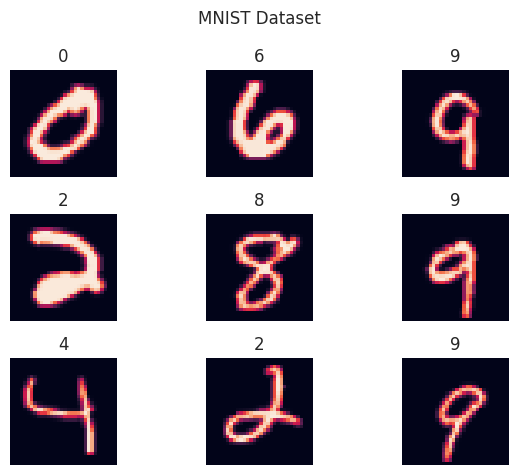

In [5]:
def show_batch(data, idx=0):
    
    fig, ax = plt.subplots(nrows=3, ncols=3)
    
    batch = next(iter(data))
    images, labels = batch[0], batch[1]

    for row in range(3):
        for column in range(3):
            ax[row, column].imshow(images[3*row + column][0, :, :])
            ax[row, column].axis('off')
            ax[row, column].set_title(int(labels[3*row+column]))
            
    plt.suptitle("MNIST Dataset")
    plt.tight_layout()
    plt.show()
    
show_batch(train_loader)

# LeNet5 Architecture

In [6]:
class ConvBlock(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: int,
                 stride: int,
                 padding: int = 0,
                 pool_kernel_size: int = 2,
                 pool_stride: int = 2):
        
        super(ConvBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding),
            #nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)
        )
        
    def forward(self, x):
        return self.block(x)
        

In [7]:
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        
        self.num_classes = num_classes
        
        self.block1 = ConvBlock(in_channels=1,
                                out_channels=6,
                                kernel_size=5,
                                stride=1,
                                padding=0)
        
        self.block2 = ConvBlock(in_channels=6,
                                out_channels=16,
                                kernel_size=5,
                                stride=1,
                                padding=0)
        
        self.relu = nn.ReLU()
        
        self.linear1 = nn.Linear(in_features=16*5*5, out_features=120) # Number of channels times kernel_size^2
        self.linear2 = nn.Linear(in_features=120, out_features=84)
        self.linear3 = nn.Linear(in_features=84, out_features=self.num_classes)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        
        x = x.reshape(x.size(0), -1) # Flattening the tensor

        x = self.linear1(x)
        x = x.relu()
        
        x = self.linear2(x)
        x = x.relu()
        
        x = self.linear3(x)
        
        return x

In [8]:
lenet5 = LeNet5(num_classes=10)

In [9]:
from torchinfo import summary

summary(model=lenet5, input_size=(1, 1, 32, 32), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5 (LeNet5)                          [1, 1, 32, 32]       [1, 10]              --                   True
├─ConvBlock (block1)                     [1, 1, 32, 32]       [1, 6, 14, 14]       --                   True
│    └─Sequential (block)                [1, 1, 32, 32]       [1, 6, 14, 14]       --                   True
│    │    └─Conv2d (0)                   [1, 1, 32, 32]       [1, 6, 28, 28]       156                  True
│    │    └─ReLU (1)                     [1, 6, 28, 28]       [1, 6, 28, 28]       --                   --
│    │    └─MaxPool2d (2)                [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
├─ConvBlock (block2)                     [1, 6, 14, 14]       [1, 16, 5, 5]        --                   True
│    └─Sequential (block)                [1, 6, 14, 14]       [1, 16, 5, 5]        --                   True
│    │    └─Conv2d

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [11]:
lenet5 = lenet5.to(device)

In [12]:
def training_setup(learning_rate, model):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    return loss, optimizer


loss_module, optimizer = training_setup(learning_rate=1e-3,
                                        model=lenet5)

In [13]:
def train(model,
          num_epochs,
          device,
          loss_module,
          optimizer):
    
    total_steps = len(train_loader)
    
    history = []
    
    for epoch in tqdm(range(num_epochs)):
        
        train_loss = 0.0
        
        for i, (images, labels) in enumerate(train_loader):
            
            model.train()
            
            images = images.to(device)
            labels = labels.to(device)
            
            preds = model(images)
            loss = loss_module(preds, labels)
            
            train_loss += loss.item()
            
            #Backward and Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_loss /= len(train_loader)
            
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss}")
                
        history.append(train_loss)
        
    sns.lineplot(history).set_title('Loss vs Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
        
    return history

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10] - Train Loss: 0.22009660110179421
Epoch [2/10] - Train Loss: 0.06596680443663436
Epoch [3/10] - Train Loss: 0.047346989682161694
Epoch [4/10] - Train Loss: 0.03715840441016937
Epoch [5/10] - Train Loss: 0.03190700284286421
Epoch [6/10] - Train Loss: 0.025416715551718278
Epoch [7/10] - Train Loss: 0.02342141544609042
Epoch [8/10] - Train Loss: 0.019552341001383193
Epoch [9/10] - Train Loss: 0.01663938439123197
Epoch [10/10] - Train Loss: 0.015528841060603727


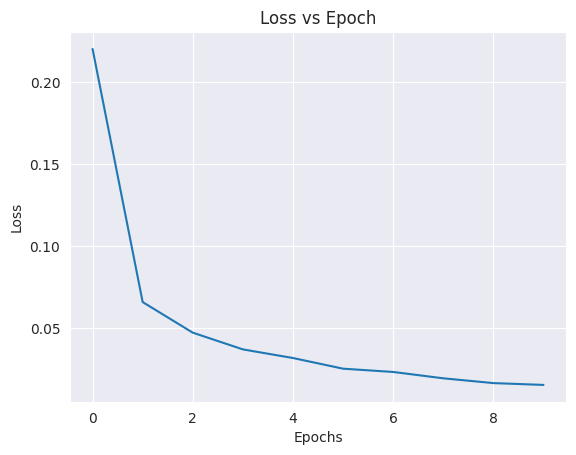

In [14]:
history = train(model=lenet5,
                  num_epochs=10,
                  device=device,
                  loss_module=loss_module,
                  optimizer=optimizer)

In [15]:
from torchmetrics import Accuracy

test_loss, test_acc = 0, 0

lenet5.to(device)

accuracy = Accuracy(task='multiclass', num_classes=10)
accuracy.to(device)

lenet5.eval()

with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = lenet5(X)
        
        test_loss += loss_module(y_pred, y)
        test_acc += accuracy(y_pred, y)
        
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

print(f"Test loss: {test_loss: .5f}| Test acc: {test_acc: .5f}")

Test loss:  0.03686| Test acc:  0.98975
